In [1]:
# core python
import dask
import numpy as np
import datetime
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.constants import mu_0, inch, foot
from scipy.spatial import cKDTree
import os
import ipywidgets
import time
from string import ascii_lowercase
from matplotlib import rcParams
from matplotlib import gridspec

# SimPEG, discretize
import discretize
from discretize import utils
from SimPEG.electromagnetics import time_domain as tdem
from SimPEG import utils, maps
from pymatsolver import Pardiso

# casing utility code 
import casingSimulations as casingSim

%matplotlib inline

In [2]:
from pyMKL import mkl_set_num_threads
# use a single thread 
# num_threads = 1
# mkl_set_num_threads(num_threads)

In [57]:
from matplotlib import rcParams
rcParams["font.size"] = 14

## model parameters

In [4]:
# conductivities
sigma_air = 1e-4
sigma_back = 1e-2
sigma_casing = sigma_back
sigma_casing = 5e6

# relative permeability of the casing
mur_casing = 1.

# casing geometry
casing_diameter = 10e-2  
casing_t = 10e-3
casing_l = 1000

# cell size in the z-direction for the mesh
csz = 2.5 
# csz=1.25

Source electrode locations. The source runs along the $\theta = 90^{\circ}$ line

In [5]:
src_a = np.r_[casing_diameter / 2., np.pi/2, 0.]
src_b = np.r_[casing_l, np.pi/2, 0.]

In [6]:
model = casingSim.model.CasingInHalfspace(
    casing_d = casing_diameter - casing_t,  # I use diameter to the center of the casing wall
    casing_l = casing_l,
    casing_t = casing_t, 
    mur_casing = mur_casing,
    sigma_air = sigma_air,
    sigma_casing = sigma_casing,
    sigma_back = sigma_back,
    sigma_inside = sigma_back,
    src_a = src_a,
    src_b = src_b
)
model.filename = "casing.json"

Create the time-stepping for the forward simulation

In [7]:
timeSteps = [
    (1e-6, 20), (1e-5, 30), (3e-5, 30), (1e-4, 40), (3e-4, 30), (1e-3, 20), (1e-2, 17)
]

model.timeSteps = timeSteps

print("The latest time is {:1.1e}s".format(model.timeSteps.sum()))
print("There are {} time-steps in the simulation, {} are unique "
      "(this controls how many matrix factorizations need to be done)".format(
          len(model.timeSteps), len(np.unique(np.diff(model.timeSteps)))
      )
)

The latest time is 2.0e-01s
There are 187 time-steps in the simulation, 7 are unique (this controls how many matrix factorizations need to be done)


Duplicate the model so that we can run a `background` model that does not include casing.

In [8]:
print(model.diffusion_distance(1))


12615.6626101008


In [9]:
model_background = model.copy()
model_background.sigma_casing = model_background.sigma_back
model_background.filename = "background.json"

In [10]:
def x2(x):
    return x**2
ipywidgets.interact(x2, x=ipywidgets.FloatSlider(min=-1, max=1))

interactive(children=(FloatSlider(value=0.0, description='x', max=1.0, min=-1.0), Output()), _dom_classes=('wi…

<function __main__.x2(x)>

### create "approximate" models
- treat the well as a solid cylinder
- use a conductivity equal to that product of the conductivity and cross-sectional area of the casing
- to approximate the permeability, I preserve the product of the permeability and the thickness of the casing wall

In [11]:
# preserve product of conductivity and cross-sectional area for solid cylinder 
sigmaA = model.sigma_casing * (model.casing_b**2 - model.casing_a**2)/model.casing_b**2
print(f"The approximate conductivity of the solid we use is {sigmaA:1.1e}")

model_approx_casing = model.copy()
model_approx_casing.sigma_inside = sigmaA
model_approx_casing.sigma_casing = sigmaA
model_approx_casing.filename = "approx_casing.json"

model_solid_steel = model_approx_casing.copy()
model_solid_steel.sigma_inside = model.sigma_casing
model_solid_steel.sigma_casing = model.sigma_casing
model_solid_steel.filename = "solid_steel.json"

The approximate conductivity of the solid we use is 1.8e+06


keep track of the models in a dictionary

In [12]:
model_names = ["casing", "approx_casing", "solid_steel"] 
models = [model, model_approx_casing, model_solid_steel]
model_dict = dict(zip(
    model_names, 
    models 
))

## Mesh

We set up a 3D cylindrical mesh for the simulations. Both the casing and background models will be run on the same mesh. 

In [13]:
model.diffusion_distance()

5701.1071274119095

In [14]:
# Theta discretization
hy = np.ones(12)
hy = hy*2*np.pi / hy.sum()

In [15]:
meshGen = casingSim.mesh.CasingMeshGenerator(
    modelParameters = model, 
    csx1 = model.casing_t/4,
    csx2 = 100,
    domain_x = casing_l,  # use 2.5m cells out to 300m. 
    hy = hy,
    npadx = 8, # 6
    npadz = 17,  #14
#     npadx = 10, 
#     npadz = 19,
    csz = csz,
)
# meshGen.save()

In [16]:
mesh = meshGen.mesh

In [17]:
print("The mesh has {} cells".format(meshGen.mesh.nC))

The mesh has 426240 cells


plot the mesh

/global/homes/l/lheagy/.conda/envs/simpeg37/lib/python3.7/site-packages/matplotlib/projections/polar.py:55: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 0, r, np.nan)


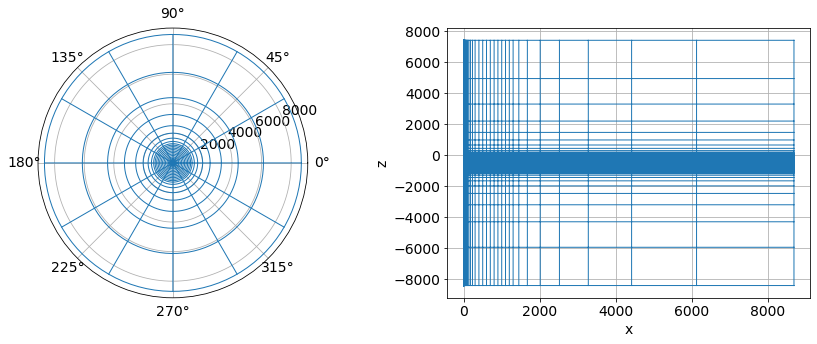

In [18]:
ax = mesh.plotGrid()

## Physical Properties

Now that we have a mesh and a model defined, we populate the mesh with physical properties

In [19]:
physprops_dict = {
    key: casingSim.model.PhysicalProperties(
        modelParameters=m, meshGenerator=meshGen
    )
    for key, m in model_dict.items() 
}


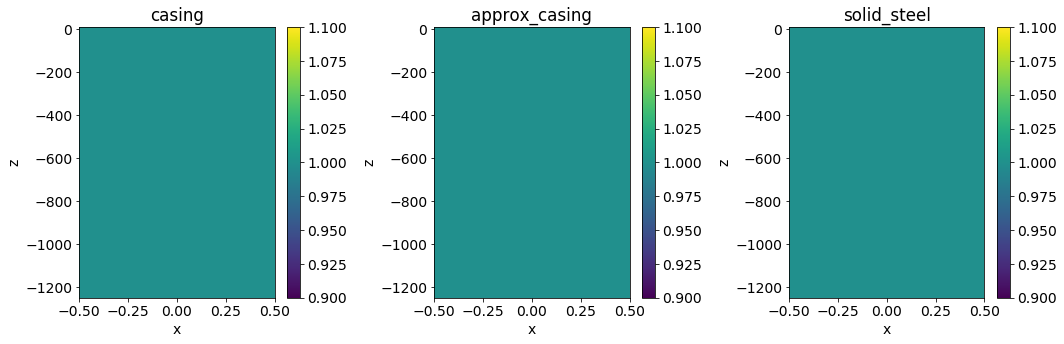

In [21]:
fig, ax = plt.subplots(1, len(model_names), figsize=(5*len(model_names), 5))

xlim = 0.5*np.r_[-1., 1.]
ylim = np.r_[-1.25*casing_l, 10.]

for m, a in zip(model_names, ax):
    physprops_dict[m].plot_mur(ax=a)
    a.set_xlim(xlim)
    a.set_ylim(ylim) 
    a.set_title(m)

plt.tight_layout()

## Survey

The source is a grounded source with one electrode at 1000m and the other electrode connected to the top of the casing. A wire connects them. Note that we will use H-J formulation t solve this problem, so the source is defined as current that goes through the faces of the mesh. 

In [22]:
src_theta = np.pi/2. + mesh.hy[0]/2.
model.src_a[1] = src_theta
model.src_b[1] = src_theta

In [23]:
top_src_a = model.src_a.copy()
top_src_a[2] = 0

In [24]:
downhole_src_a = model.src_a.copy()
downhole_src_a[0] = 0.
downhole_src_a[2] = -950.

In [25]:
src_top = casingSim.sources.TopCasingSrc(
    modelParameters=model, 
    meshGenerator=meshGen,
    src_a=top_src_a,
    src_b=model.src_b,
    physics="TDEM",
    filename="top_casing",
)

src_downhole = casingSim.sources.DownHoleCasingSrc(
    modelParameters=model,
    meshGenerator=meshGen,
    src_a=downhole_src_a,
    src_b=model.src_b,
    physics="TDEM",
    filename="downhole",
)

sources = [src_top, src_downhole]
srcList = src_top.srcList + src_downhole.srcList

In [26]:
casingSimSrcList = casingSim.sources.SourceList(
    filename="sources.json",
    sources = sources  
)

source_list = casingSimSrcList.srcList

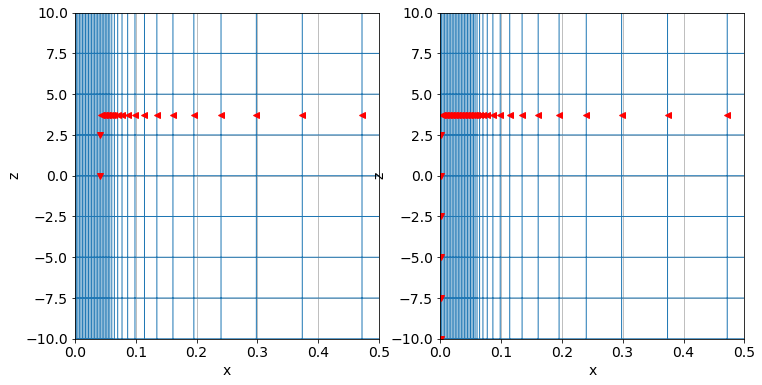

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

for a, src in zip(ax, sources): 
    meshGen.mesh.plotGrid(slice='theta', ax=a)
    src.plot(ax=a)

    a.set_xlim([0., 0.5])
    a.set_ylim([-10., 10.])

## Simulation

In [28]:
run = False
use_cluster = False #True
# run = True
# use_cluster = True

In [29]:
survey = tdem.Survey(source_list)

In [30]:
formulation = "j"

if formulation == "h":
    sim = tdem.Problem3D_h(
        mesh=mesh, survey=survey, sigmaMap=maps.IdentityMap(mesh), solver=Pardiso,
        time_steps=timeSteps
    )
elif formulation == "j":
    sim = tdem.Problem3D_j(
        mesh=mesh, survey=survey, sigmaMap=maps.IdentityMap(mesh), solver=Pardiso,
        time_steps=timeSteps
    )

In [31]:
import dask
import dask_jobqueue
from dask.distributed import Client
from dask.diagnostics import ProgressBar

In [32]:
# dask_jobqueue.SLURMCluster??

In [33]:
if use_cluster is True: 
    cluster = dask_jobqueue.SLURMCluster(
        cores=len(model_names),
        processes=len(model_names), memory='120GB', 
        job_cpu=5*len(model_names),
        project="m3384",
        job_extra = ['--constraint=haswell', '--qos=debug',], 
        death_timeout=360,
    )

    print(cluster.job_script())

In [34]:
# Client?

In [35]:
if use_cluster is True: 
    client = Client(cluster)
else: 
    client = Client(threads_per_worker=1, n_workers=1)
client

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


KeyboardInterrupt: 

In [36]:
# @dask.delayed
def run_simulation(m, simulation_params, directory=None, name=None):
    import discretize
    import casingSimulations as casing_sim
    from SimPEG.electromagnetics import time_domain as tdem
    from pymatsolver import Pardiso
        
    if isinstance(simulation_params, str):
        simulation_params = json.loads(simulation_params)
    
    sim = tdem.Problem3D_j.deserialize(simulation_params, trusted=True)
    
    if isinstance(m, str):
        model = casing_sim.model.CasingInHalfspace.deserialize(json.loads(m), trusted=True)
        m = model.sigma(sim.mesh)
    
    sim.solver = Pardiso
    sim.verbose = True
    
    fields = sim.fields(m)
    f = fields[:, '{}Solution'.format(sim._fieldType), :]
    if name is not None: 
        filename = f"{name}.npy"
        tosave = os.path.sep.join([directory, filename]) 
        print(f"saving {tosave}")
        np.save(tosave, f)
    return tosave

In [37]:
if use_cluster is True:
    cluster.adapt()
#     cluster.scale(3)
    print("cluster scaled")
    cluster

In [38]:
if run is True: 
    f = {}
    for key, value in physprops_dict.items():
        time = datetime.datetime.now()
        model = model_dict[key]
        directory = f"{time.year}{time.month}{time.day}{time.hour}{os.path.sep}{int(model.casing_l)}m_sigma{model.sigma_back:1.0e}"

        if not os.path.isdir(directory):
            os.makedirs(directory, exist_ok=True)

        model.save(f"{key}.json", directory)
        sigma = dask.delayed(value.sigma)
        f[key] = dask.delayed(run_simulation)(
            value.sigma, sim.serialize(), directory, key
        )
    
    

In [39]:
if run is True: 
    fields_files = dask.compute(f)[0]
else:
    fields_files = {}
#     directory = "20198821/1000m_sigma1e-02/"
#     directory = '20198413/1000m_sigma1e-02/'
#     directory = "20199317/1000m_sigma1e-02/"
    directory = "/project/projectdirs/m3384/lheagy/heagy-2019-casing-ml/forward_simulations/1000m_sigma1e-02/"
    for key in model_names:
        fields_files[key] = f"{directory}{key}.npy"

load the results into memory and re-populate the fields object (this takes a couple minutes). 

In [40]:
fields_files

{'casing': '/project/projectdirs/m3384/lheagy/heagy-2019-casing-ml/forward_simulations/1000m_sigma1e-02/casing.npy',
 'approx_casing': '/project/projectdirs/m3384/lheagy/heagy-2019-casing-ml/forward_simulations/1000m_sigma1e-02/approx_casing.npy',
 'solid_steel': '/project/projectdirs/m3384/lheagy/heagy-2019-casing-ml/forward_simulations/1000m_sigma1e-02/solid_steel.npy'}

In [41]:
solution_dict = {}
for key, val in fields_files.items():
    solution_dict[key] = np.load(val)

In [42]:
m = model_dict['casing']

In [43]:
if use_cluster is True: 
    cluster.close()

#### todo: profile this at some point - the fields object should not be this expensive to create

In [44]:
solution_dict["approx_casing"].shape

(1279680, 2, 188)

In [45]:
fields_dict = {}

for key in model_names:
    print(key)
    sim.model = model_dict[key].sigma(sim.mesh)
    fields_dict[key] = sim.fieldsPair(sim)
    fields_dict[key][:, f'{formulation}Solution', :] = solution_dict.pop(key)

casing
approx_casing
solid_steel


In [62]:
viewer = casingSim.FieldsViewer(
    mesh=mesh, model_parameters_dict=model_dict, survey_dict={key: sim.survey for key in model_names}, 
    fields_dict=fields_dict, model_keys=model_names, primary_key="casing"
)

In [63]:
out1 = viewer.widget_cross_section(
    defaults={
        "max_depth":1.1*model.casing_l,
        "min_depth":-10,
        "max_r":0.15,
        "theta_ind":3, 
        "view":"j", 
#         "time_ind":73, 
        "model_key":"casing",
        "clim_min": 1e-7,
        "clim_max":1e2,
        "prim_sec":"total",
    }
)
out1

interactive(children=(FloatText(value=0.15, description='max_r'), FloatText(value=-10.0, description='min_dept…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

In [48]:
from matplotlib import rcParams
rcParams['font.size'] = 14

In [49]:
viewer.primary = "casing"

In [50]:
viewer.widget_cross_section(
    defaults={
        "max_depth":1.5*model.casing_l,
        "min_depth":-10,
        "max_r":1.5*model.casing_l,
        "theta_ind":3,
        "view":"j"
    }, 
    figwidth=12
)

interactive(children=(FloatText(value=1500.0, description='max_r'), FloatText(value=-10.0, description='min_de…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

In [51]:
rcParams["font.size"] = 20

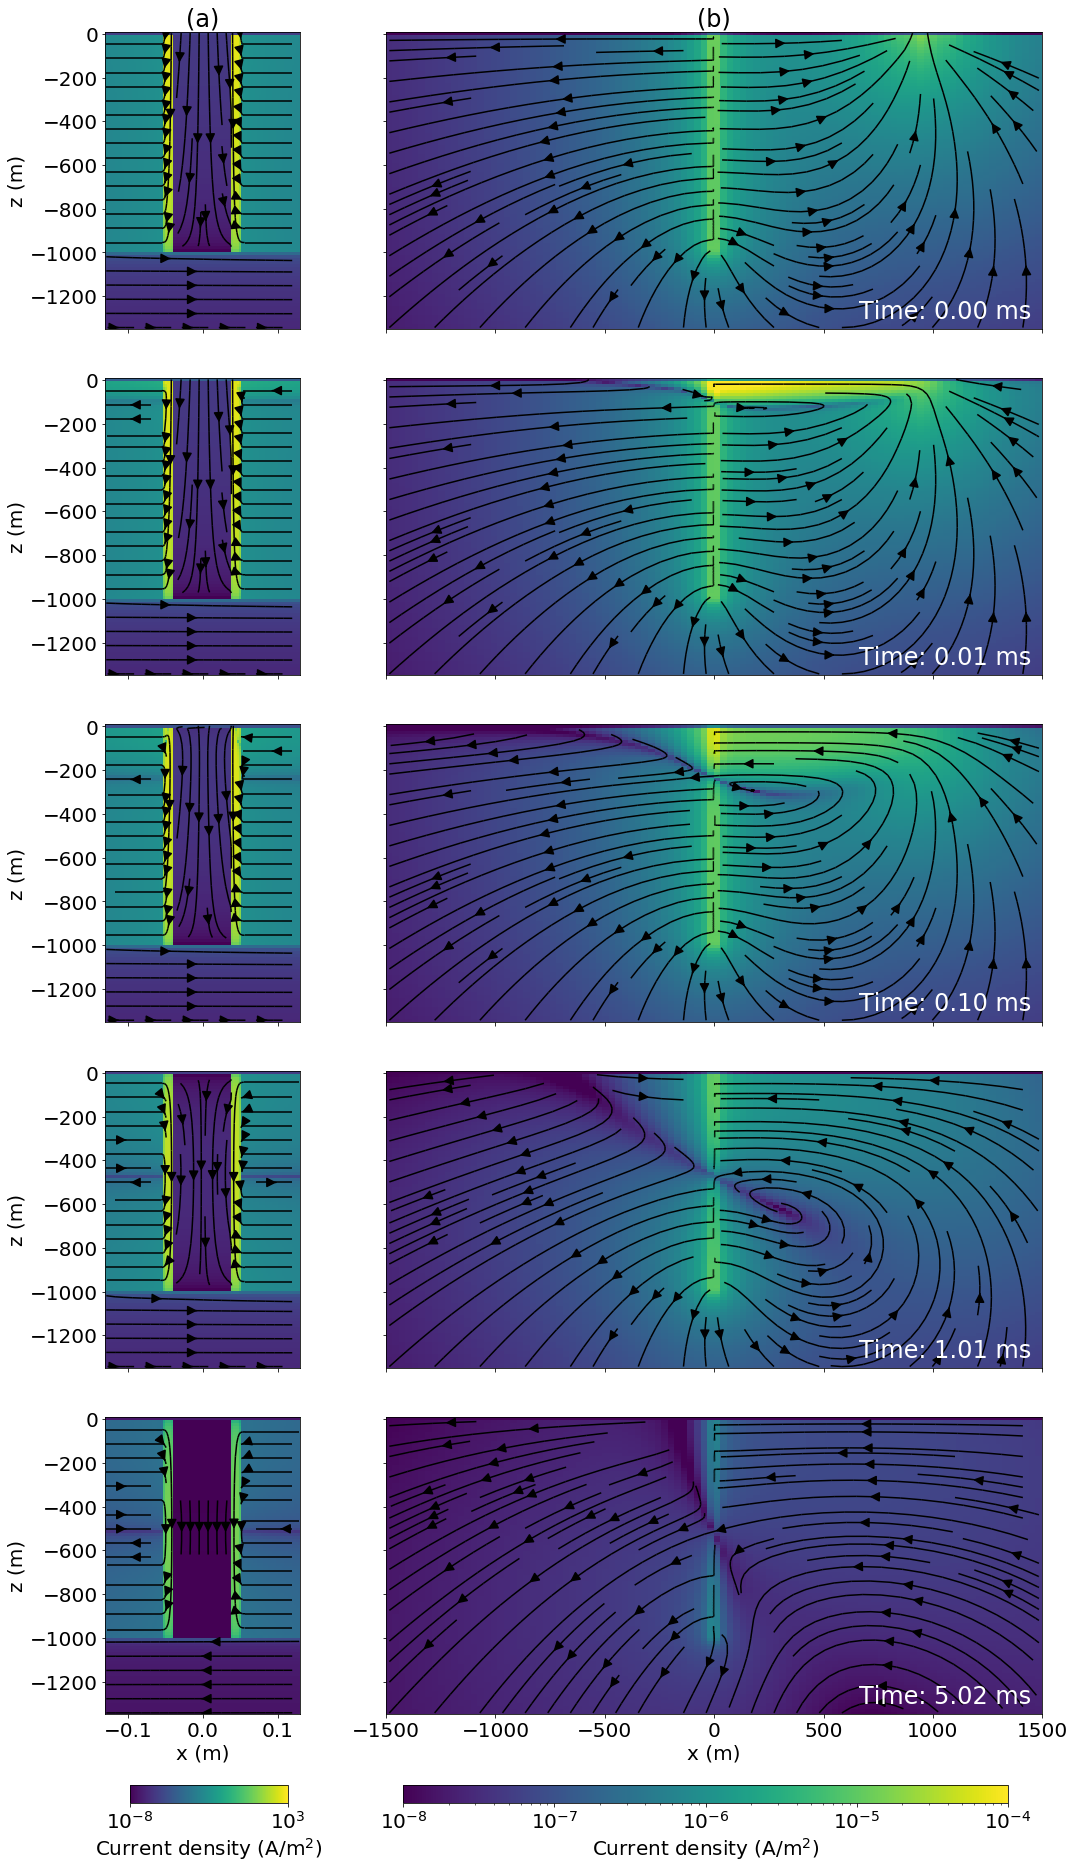

In [53]:
plt_times = [0, 10, 28, 73, 118]
clim_max = 1e-4 
clim_min = 1e-8
clim = np.r_[clim_min, clim_max]

clim_max_casing = 1e3
clim_min_casing = 1e-8
# clim_max_casing = 1e2
# clim_min_casing = 1e-7

clim_casing = np.r_[clim_min_casing, clim_max_casing]

max_depth = 1.35*casing_l
max_r_casing = 0.13
top=10.

xlim = 1500.*np.r_[-1., 1.]

# x_ticks = [0, -500, -1000, -1500]

# fig, ax = plt.subplots(4, len(plt_times), figsize )

fig = plt.figure(figsize=(20, 5*len(plt_times))) 
fig.subplots_adjust(bottom=0.8)

gs = gridspec.GridSpec(len(plt_times), 2, width_ratios=[0.12, 0.85]) 
ax = [plt.subplot(gs[i]) for i in range(len(plt_times)*2)]

stream_opts = {"color": "k", "arrowsize": 2}

for i, tind in enumerate(plt_times):
    
    ax0 = ax[i*2 + 0]
    ax1 = ax[i*2 + 1]
    
    # zoomed in plot
    out_casing = viewer.plot_cross_section(
        ax=ax0, clim=clim_casing, zlim=np.r_[-max_depth, top],
        xlim=max_r_casing*np.r_[-1., 1.],
        view='j', theta_ind=3, time_ind=tind, 
        model_key='casing', show_cb=False, casing_outline=False,
        stream_opts={"density":0.75, "color": "k", "arrowsize": 2}
    )
    ax0.set_ylim(np.r_[-max_depth, top])
    ax0.set_ylabel('z (m)')
    
    # currents in the formation
    out = viewer.plot_cross_section(
        ax=ax1, clim=clim, zlim=np.r_[-max_depth, top],
        xlim=xlim, view='j', theta_ind=3, time_ind=tind, 
        model_key='casing', show_cb=False, use_aspect=True,
        casing_outline=False, stream_opts=stream_opts
    )
    ax1.text(1450, -1300, "Time: {:.2f} ms".format(sim.times[tind]*1e3), horizontalalignment="right", color='w', fontsize=24)  
    
    for a in [ax0, ax1]:
        a.set_title('')
        if a != ax0: 
            a.set_aspect(1)
        
            
        if tind == plt_times[-1]:
            a.set_xlabel('x (m)')
        else: 
            a.set_xticklabels(['']*len(a.get_xticklabels()))
            a.set_xlabel('')
        
        if a in [ax1]:
            a.set_ylabel('')
            a.set_yticklabels(['']*len(a.get_yticklabels()))
    
#         if a == ax1:
#             a.set_ylabel('y (m)')
        
            
    if tind == 0:
        ax0.set_title('(a)')
        ax1.set_title('(b)')
    
    
        
plt.tight_layout()

cbar_ax2 = fig.add_axes([0.1, -0.01, 0.11, 0.01])
cb2 = plt.colorbar(out_casing[0], cbar_ax2, orientation='horizontal')
cb2.set_label('Current density (A/m$^2$)')
cb2.set_ticks(clim_casing)
cb2.update_ticks()

cbar_ax = fig.add_axes([0.29, -0.01, 0.42, 0.01])
cb = plt.colorbar(out[0], cbar_ax, orientation='horizontal')
cb.set_label('Current density (A/m$^2$)')


plt.show()

# fig.savefig('../figures/casing-currents.png', dpi=150)
# fig.savefig('../arxiv-figures/casing-currents.png', dpi=50)

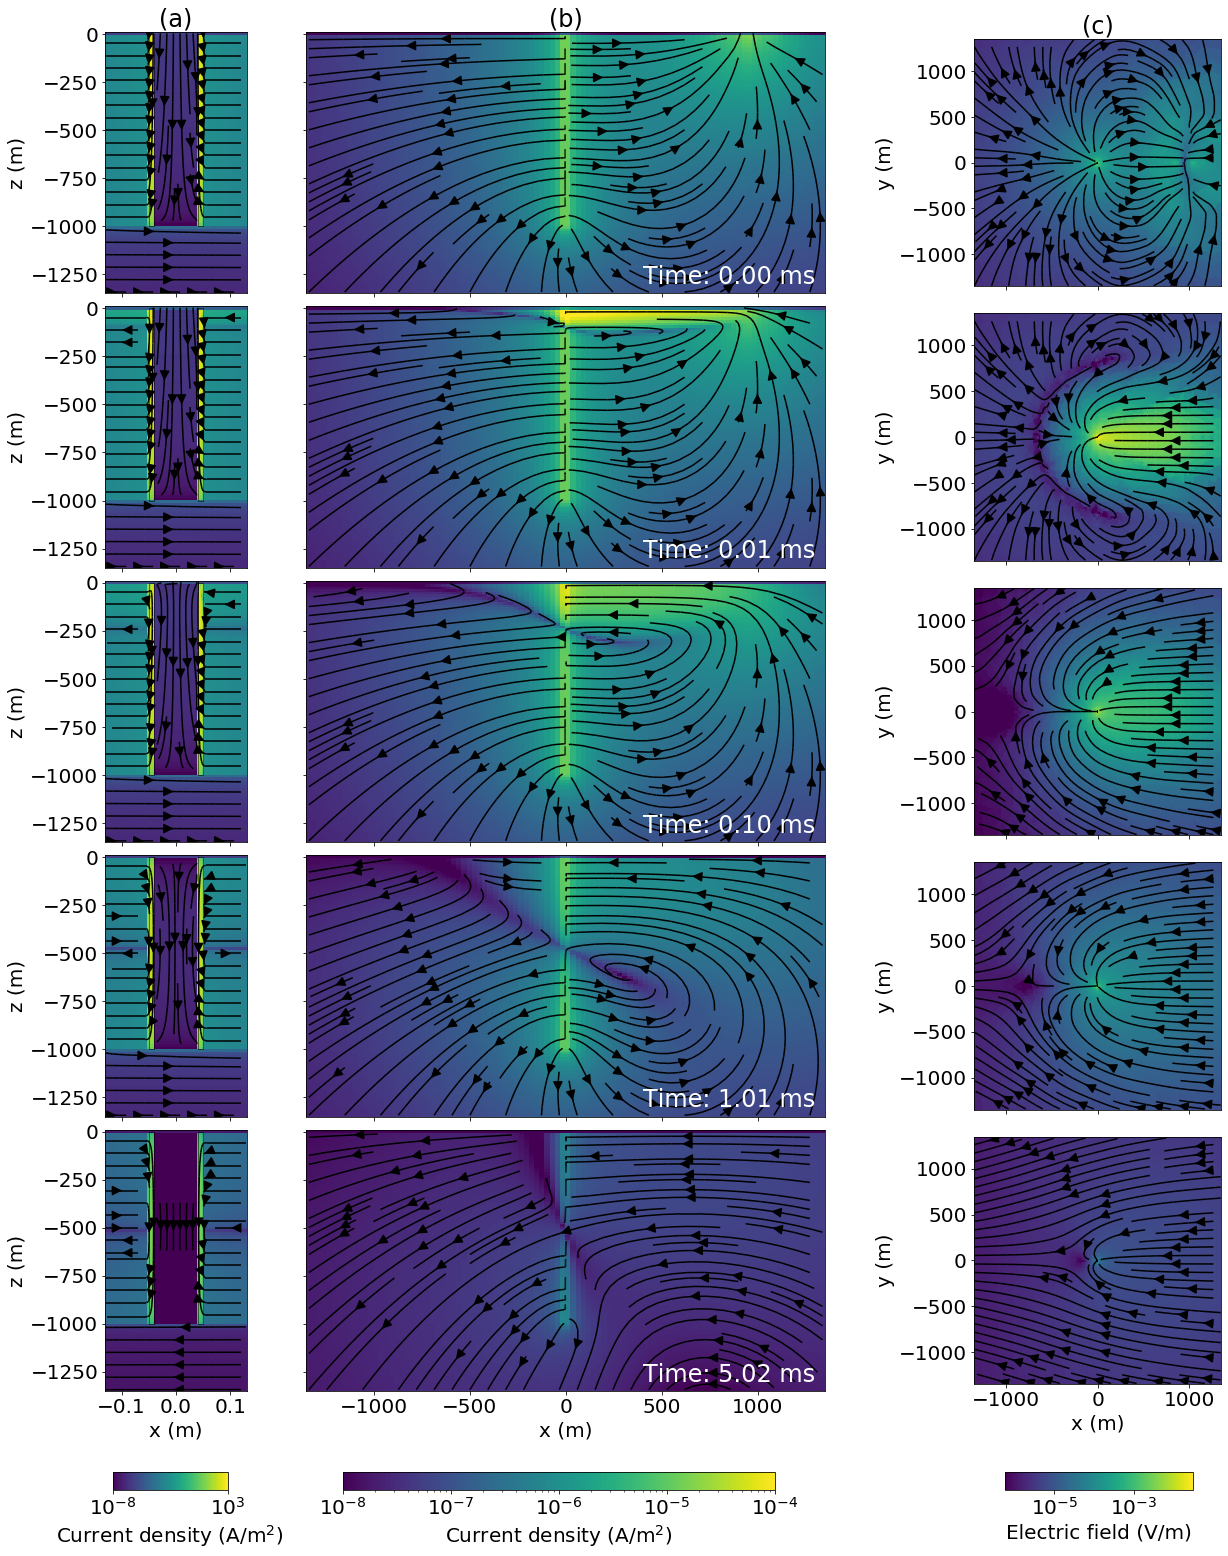

In [56]:
plt_times = [0, 10, 28, 73, 118]
key = "casing"
prim_sec = "total"

clim_max = 1e-4 
clim_min = 1e-8
clim = np.r_[clim_min, clim_max]

clim_max_casing = 1e3
clim_min_casing = 1e-8
# clim_max_casing = 1e2
# clim_min_casing = 1e-7

clim_casing = np.r_[clim_min_casing, clim_max_casing]

clim_e_field = np.r_[6e-7, 3e-2]

max_depth = 1.35*casing_l
max_r_casing = 0.13
top=10.

xlim = max_depth*np.r_[-1., 1.]
zind = 421  # just beneath the surface of the earth

# x_ticks = [0, -500, -1000, -1500]

# fig, ax = plt.subplots(4, len(plt_times), figsize )

fig = plt.figure(figsize=(20, 5*len(plt_times))) 
# fig.subplots_adjust(bottom=0.8)

gs = gridspec.GridSpec(len(plt_times), 4, width_ratios=[0.2, 0.85, 0.1, 0.35], hspace=0.05, wspace=0.07) 
ax = [plt.subplot(gs[i]) for i in range(len(plt_times)*4)]

stream_opts = {"color": "k", "arrowsize": 2}

for i, tind in enumerate(plt_times):
    
    ax0 = ax[i*4 + 0]
    ax1 = ax[i*4 + 1]
    ax2 = ax[i*4 + 3]
#     ax3 = ax[i*4 + 4]
    ax_blank = ax[i*4 + 2]
    
    ax_blank.set_axis_off()
    
    # zoomed in plot
    out_casing = viewer.plot_cross_section(
        ax=ax0, clim=clim_casing, zlim=np.r_[-max_depth, top],
        xlim=max_r_casing*np.r_[-1., 1.],
        view='j', theta_ind=3, time_ind=tind, 
        model_key=key, show_cb=False, casing_outline=True, prim_sec=prim_sec,
        stream_opts={"density":0.75, "color": "k", "arrowsize": 2}
    )
    ax0.set_ylim(np.r_[-max_depth, top])
    ax0.set_ylabel('z (m)')
    
    # currents in the formation
    out = viewer.plot_cross_section(
        ax=ax1, clim=clim, zlim=np.r_[-max_depth, top],
        xlim=xlim, view='j', theta_ind=3, time_ind=tind, 
        model_key=key, show_cb=False, use_aspect=True, prim_sec=prim_sec, 
        casing_outline=False, stream_opts=stream_opts
    )
    ax1.text(1300, -1300, "Time: {:.2f} ms".format(sim.times[tind]*1e3), horizontalalignment="right", color='w', fontsize=24)
    
    # electric field at the surface
    out_e = viewer.plot_depth_slice(
        model_key=key, prim_sec=prim_sec, view="e",
        ax=ax2, xlim=np.r_[-max_depth, max_depth], ylim=np.r_[-max_depth, max_depth], use_aspect=True,
        z_ind=zind, time_ind=tind, show_cb=False, rotate=True, theta_shift=mesh.hy[0]/2,
        stream_opts=stream_opts, clim=clim_e_field
    )
    
    for a in [ax0, ax1, ax2]:
        a.set_title('')
        if a != ax0: 
            a.set_aspect(1)
        
            
        if tind == plt_times[-1]:
            a.set_xlabel('x (m)')
        else: 
            a.set_xticklabels(['']*len(a.get_xticklabels()))
            a.set_xlabel('')
        
        if a in [ax1]:
            a.set_ylabel('')
            a.set_yticklabels(['']*len(a.get_yticklabels()))
    
        if a == ax2:
            a.set_ylabel('y (m)')
        
            
    if tind == 0:
        ax0.set_title("(a)")
        ax1.set_title("(b)")
        ax2.set_title("(c)")
#         ax3.set_title("(d)")
    
    
        
# plt.tight_layout()

cbh = 0.07
cbar_ax2 = fig.add_axes([0.13, cbh, 0.08, 0.01])
cb2 = plt.colorbar(out_casing[0], cbar_ax2, orientation='horizontal')
cb2.set_label('Current density (A/m$^2$)')
cb2.set_ticks(clim_casing)
cb2.update_ticks()

cbar_ax = fig.add_axes([0.29, cbh, 0.3, 0.01])
cb = plt.colorbar(out[0], cbar_ax, orientation='horizontal')
cb.set_label('Current density (A/m$^2$)')

cbar_e_ax = fig.add_axes([0.75, cbh, 0.13, 0.01])
cbe = plt.colorbar(out_e[0], cbar_e_ax, orientation="horizontal")
cbe.set_label("Electric field (V/m)")

plt.show()

fig.savefig('../figures/casing-currents.png', dpi=100, bbox_inches="tight")
fig.savefig('../arxiv-figures/casing-currents.png', dpi=50, bbox_inches="tight")

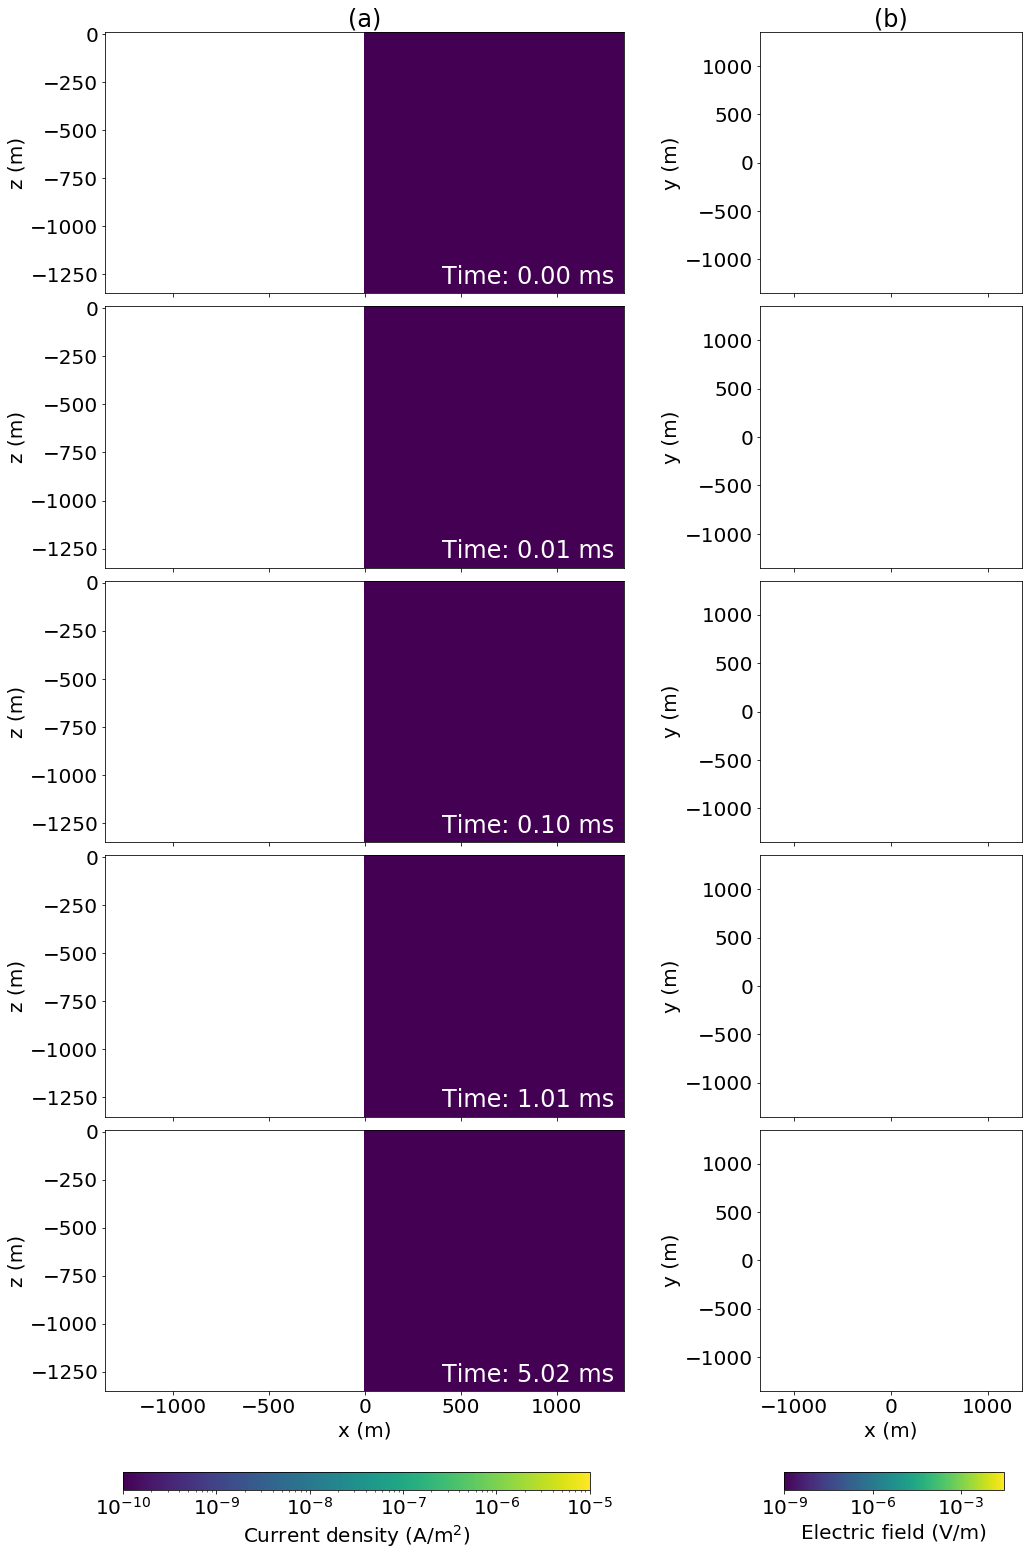

In [55]:
plt_times = [0, 10, 28, 73, 118]
key = "approx_casing"
prim_sec = "secondary"

clim_max = 1e-5 
clim_min = 1e-10
clim = np.r_[clim_min, clim_max]

clim_max_casing = 1e3
clim_min_casing = 1e-8
# clim_max_casing = 1e2
# clim_min_casing = 1e-7

clim_casing = np.r_[clim_min_casing, clim_max_casing]

clim_e_field = np.r_[1e-9, 3e-2]

max_depth = 1.35*casing_l
max_r_casing = 0.13
top=10.

xlim = max_depth*np.r_[-1., 1.]
zind = 421  # just beneath the surface of the earth

# x_ticks = [0, -500, -1000, -1500]

# fig, ax = plt.subplots(4, len(plt_times), figsize )

fig = plt.figure(figsize=(18, 5*len(plt_times))) 
# fig.subplots_adjust(bottom=0.8)

gs = gridspec.GridSpec(len(plt_times), 2, width_ratios=[0.85, 0.35], hspace=0.05, wspace=0.1) 
ax = [plt.subplot(gs[i]) for i in range(len(plt_times)*2)]

stream_opts = {"color": "k", "arrowsize": 2}

for i, tind in enumerate(plt_times):
    
#     ax0 = ax0[i*4 + 0]
    ax1 = ax[i*2 + 0]
    ax2 = ax[i*2 + 1]
#     ax3 = ax[i*4 + 2]
#     ax4 = ax[i*4 + 3]
    
#     ax_blank = ax[i*4 + 1]
#     ax_blank.set_axis_off()
    
    # zoomed in plot
#     out_casing = viewer.plot_cross_section(
#         ax=ax0, clim=clim_casing, zlim=np.r_[-max_depth, top],
#         xlim=max_r_casing*np.r_[-1., 1.],
#         view='j', theta_ind=3, time_ind=tind, 
#         model_key=key, show_cb=False, casing_outline=True, prim_sec=prim_sec,
#         stream_opts={"density":0.75, "color": "k", "arrowsize": 2}
#     )
#     ax0.set_ylim(np.r_[-max_depth, top])
#     ax0.set_ylabel('z (m)')
    
    # currents in the formation
    out = viewer.plot_cross_section(
        ax=ax1, clim=clim, zlim=np.r_[-max_depth, top],
        xlim=xlim, view='j', theta_ind=3, time_ind=tind, 
        model_key=key, show_cb=False, use_aspect=True, prim_sec=prim_sec, 
        casing_outline=False, stream_opts=stream_opts
    )
    ax1.text(1300, -1300, "Time: {:.2f} ms".format(sim.times[tind]*1e3), horizontalalignment="right", color='w', fontsize=24)
    ax1.set_ylabel('z (m)')
    
    # electric field at the surface
    out_e = viewer.plot_depth_slice(
        model_key=key, prim_sec=prim_sec, view="e",
        ax=ax2, xlim=np.r_[-max_depth, max_depth], ylim=np.r_[-max_depth, max_depth], use_aspect=True,
        z_ind=zind, time_ind=tind, show_cb=False, rotate=True, theta_shift=mesh.hy[0]/2,
        stream_opts=stream_opts, clim=clim_e_field
    )
    
#     out_e_percent = viewer.plot_depth_slice(
#         model_key=key, prim_sec="percent", view="e",
#         ax=ax3, xlim=np.r_[-max_depth, max_depth], ylim=np.r_[-max_depth, max_depth], use_aspect=True,
#         z_ind=zind, time_ind=tind, show_cb=False, rotate=True, theta_shift=mesh.hy[0]/2,
#         stream_opts=stream_opts, clim=[0, 200]
#     )
    
    for a in [ax1, ax2]:
        a.set_title('')
#         if a != ax0: 
        a.set_aspect(1)
        
            
        if tind == plt_times[-1]:
            a.set_xlabel('x (m)')
        else: 
            a.set_xticklabels(['']*len(a.get_xticklabels()))
            a.set_xlabel('')
        
#         if a in [ax1]:
#             a.set_ylabel('')
#             a.set_yticklabels(['']*len(a.get_yticklabels()))
    
        if a == ax2:
            a.set_ylabel('y (m)')
        
            
    if tind == 0:
#         ax0.set_title("(a)")
        ax1.set_title("(a)")
        ax2.set_title("(b)")
#         ax3.set_title("(c)")
    
    
        
# plt.tight_layout()

cbh = 0.07
# cbar_ax2 = fig.add_axes([0.13, cbh, 0.08, 0.01])
# cb2 = plt.colorbar(out_casing[0], cbar_ax2, orientation='horizontal')
# cb2.set_label('Current density (A/m$^2$)')
# cb2.set_ticks(clim_casing)
# cb2.update_ticks()

cbar_ax = fig.add_axes([0.2, cbh, 0.36, 0.01])
cb = plt.colorbar(out[0], cbar_ax, orientation='horizontal')
cb.set_label('Current density (A/m$^2$)')

cbar_e_ax = fig.add_axes([0.71, cbh, 0.17, 0.01])
cbe = plt.colorbar(out_e[0], cbar_e_ax, orientation="horizontal")
cbe.set_label("Electric field (V/m)")

plt.show()

fig.savefig('../figures/approximate-casing-errors.png', dpi=100, bbox_inches="tight")
fig.savefig('../arxiv-figures/approximate-casing-errors.png', dpi=50, bbox_inches="tight")

In [57]:
data_time = {}

xmin=5 
xmax=1000 
rx_times=sim.timeMesh.gridN

# indices to grab
e_tz_inds = (
    (mesh.gridFx[:, 0]>=xmin) & (mesh.gridFx[:, 0]<=xmax) & 
    (mesh.gridFx[:, 1] == mesh.vectorCCy[0]) & 
    (mesh.gridFx[:, 2] == -csz/2.)
)

x_inds = (mesh.vectorNx>=xmin) & (mesh.vectorNx<=xmax)
x = rx_x = mesh.vectorNx[x_inds]

time_inds = discretize.utils.closestPoints(sim.timeMesh, rx_times, 'N')
t = times = sim.timeMesh.gridN[time_inds]

for key in model_names:    
    if key not in data_time.keys():
        print(f"fetching {key}")
        f = fields_dict[key]
        data = []       
    
    for src_ind in range(len(f.survey.source_list)):
        e_data = f[f.survey.source_list[src_ind], 'e', time_inds]
        e_data = (e_data[:mesh.vnF[0], :])[e_tz_inds, :]  
        e_data = e_data.reshape(len(rx_x), len(times), order="F")
        data += [e_data]
    
    data_time[key] = data

/global/u2/l/lheagy/git/simpeg/simpeg/SimPEG/simulation.py:495: UserWarning: timeMesh will be depreciated in favor of time_mesh. Please update your code accordingly
  "timeMesh will be depreciated in favor of time_mesh. "


fetching casing
fetching approx_casing
fetching solid_steel


105.0686850257828
5.020000000000001


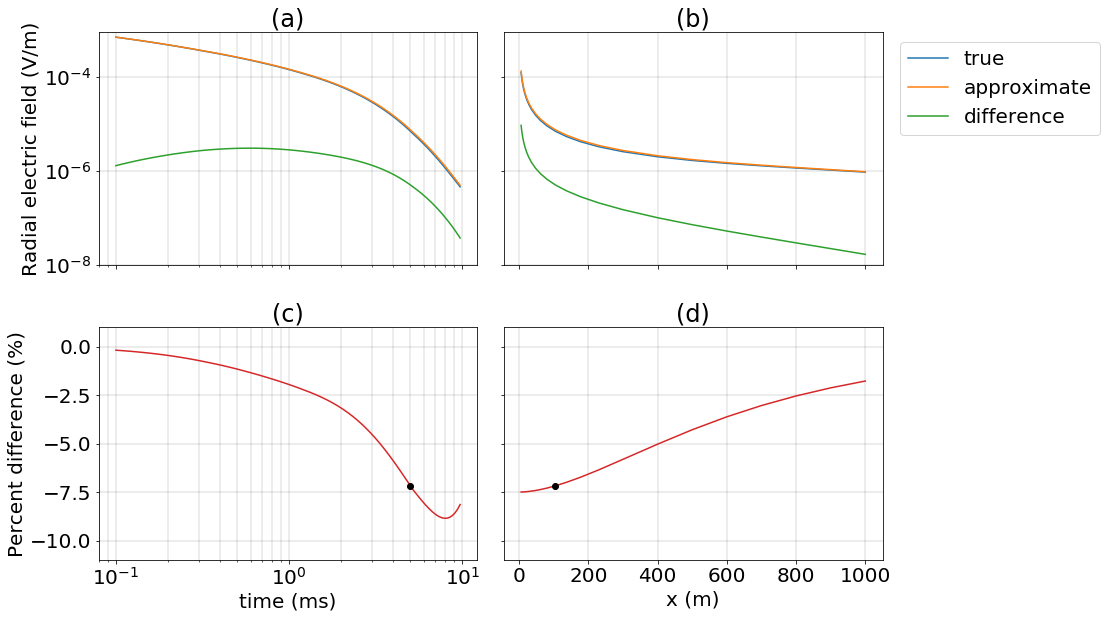

In [58]:
xind = 11
print(rx_x[xind])
src_ind = 0
tmin = 1e-4
tmax = 1e-2

time_ind = 118
print(times[time_ind]*1e3)

tinds = (t <= tmax) & (t >= tmin)

fig, ax = plt.subplots(2, 2, figsize=(16, 9))
ax = ax.flatten()


# plot a single x location 
ax[0].loglog(t[tinds]*1e3, np.abs(data_time["casing"][src_ind][xind, tinds]), label="true")
ax[0].loglog(t[tinds]*1e3, np.abs(data_time["approx_casing"][src_ind][xind, tinds]), label="approximate")

diff = data_time["approx_casing"][src_ind][xind, tinds] - data_time["casing"][src_ind][xind, tinds]
ax[0].loglog(t[tinds]*1e3, np.abs(diff), label="difference")
# ax[0].text(10, 2e-4, "x = {:.0f} m".format(rx_x[xind]), horizontalalignment="right", color='k', fontsize=24)

percent_diff = 100 * diff / np.abs(data_time["casing"][src_ind][xind, tinds])
ax[2].semilogx(t[tinds]*1e3, percent_diff, color="C3", label="difference (%)")
ax[2].set_xlabel("time (ms)")
ax[2].semilogx(t[time_ind]*1e3, percent_diff[time_ind- np.where(tinds)[0][0]], 'ko')

ax[1].semilogy(rx_x, np.abs(data_time["casing"][src_ind][:, time_ind]))
ax[1].semilogy(rx_x, np.abs(data_time["approx_casing"][src_ind][:, time_ind]))

diff = data_time["approx_casing"][src_ind][:, time_ind] - data_time["casing"][src_ind][:, time_ind]
ax[1].semilogy(rx_x, np.abs(diff), label="difference")

percent_diff = 100*diff/np.abs(data_time["casing"][src_ind][:, time_ind])
ax[3].plot(rx_x, percent_diff, color="C3", label="difference (%)")
ax[3].set_xlabel("x (m)")
ax[3].plot(rx_x[xind], percent_diff[xind], 'ko')


ax[1].legend(["true", "approximate", "difference", "difference (%)"], bbox_to_anchor=[1.6, 1])
ax[0].set_ylabel("Radial electric field (V/m)")
ax[2].set_ylabel("Percent difference (%)")

for i, a in enumerate(ax):
    a.grid(which="both", color="k", lw=0.3, alpha=0.5)
    a.set_title(f"({ascii_lowercase[i]})")
    
    if i in [0, 1]:
        a.set_xticklabels(['']*len(a.get_xticklabels()))
        a.set_xlabel('')
        a.set_ylim([1e-8, 9e-4])
        
    else:
        a.set_ylim(np.r_[-11, 1])
        
    if i in [1, 3]:
        a.set_yticklabels(['']*len(a.get_yticklabels()))
        a.set_ylabel('')
        
plt.tight_layout()

fig.savefig('../figures/surface-e-field.png', dpi=100, bbox_inches="tight")
fig.savefig('../arxiv-figures/surface-e-field.png', dpi=50, bbox_inches="tight")

In [59]:
times[time_ind- np.where(tinds)[0][0]]

0.0022200000000000006

In [60]:
t

array([0.0000e+00, 1.0000e-06, 2.0000e-06, 3.0000e-06, 4.0000e-06,
       5.0000e-06, 6.0000e-06, 7.0000e-06, 8.0000e-06, 9.0000e-06,
       1.0000e-05, 1.1000e-05, 1.2000e-05, 1.3000e-05, 1.4000e-05,
       1.5000e-05, 1.6000e-05, 1.7000e-05, 1.8000e-05, 1.9000e-05,
       2.0000e-05, 3.0000e-05, 4.0000e-05, 5.0000e-05, 6.0000e-05,
       7.0000e-05, 8.0000e-05, 9.0000e-05, 1.0000e-04, 1.1000e-04,
       1.2000e-04, 1.3000e-04, 1.4000e-04, 1.5000e-04, 1.6000e-04,
       1.7000e-04, 1.8000e-04, 1.9000e-04, 2.0000e-04, 2.1000e-04,
       2.2000e-04, 2.3000e-04, 2.4000e-04, 2.5000e-04, 2.6000e-04,
       2.7000e-04, 2.8000e-04, 2.9000e-04, 3.0000e-04, 3.1000e-04,
       3.2000e-04, 3.5000e-04, 3.8000e-04, 4.1000e-04, 4.4000e-04,
       4.7000e-04, 5.0000e-04, 5.3000e-04, 5.6000e-04, 5.9000e-04,
       6.2000e-04, 6.5000e-04, 6.8000e-04, 7.1000e-04, 7.4000e-04,
       7.7000e-04, 8.0000e-04, 8.3000e-04, 8.6000e-04, 8.9000e-04,
       9.2000e-04, 9.5000e-04, 9.8000e-04, 1.0100e-03, 1.0400e

In [61]:
np.random.rand(10)

array([0.17244325, 0.49094651, 0.29276365, 0.81443069, 0.14978635,
       0.71105884, 0.32672135, 0.37069934, 0.46917823, 0.68672972])

## Source term for the discrepancy 

In [62]:
def theta_index_mirror(theta_ind):
    return (
        theta_ind+int(mesh.vnC[1]/2)
        if theta_ind < int(mesh.vnC[1]/2)
        else theta_ind-int(mesh.vnC[1]/2)
    )

In [137]:
def compute_sm_error(src, tind=None, key="approx_casing", primary_key="casing", separate=False):
    if tind is None: 
        tind = slice(0, sim.nT)
    j_diff =  fields_dict[primary_key][src, 'j', tind] - fields_dict[key][src, 'j', tind]
    dhdt_diff = fields_dict[primary_key][src, 'dhdt', tind] - fields_dict[key][src, 'dhdt', tind]
    
    C = mesh.edgeCurl
    MfRho = mesh.getFaceInnerProduct(1./model_dict[key].sigma(mesh))
    MeMu = mesh.getEdgeInnerProduct(model_dict[key].mur(mesh)*mu_0)
    
    if separate is True:
        return (C.T * MfRho * j_diff, MeMu * dhdt_diff)
    return C.T * MfRho * j_diff + MeMu * dhdt_diff

In [138]:
def compute_se_error(src, tind=None, key="approx_casing", primary_key="casing", separate=False):
    if tind is None: 
        tind = slice(0, sim.nT)
        
    e = fields_dict[key][src, 'e', tind]
    e_diff =  fields_dict[key][src, 'e', tind] - fields_dict[primary_key][src, 'e', tind]
    
    MfRhoeI = (
        mesh.getFaceInnerProduct(1./model_dict[key].sigma(mesh), invMat=True) - 
        mesh.getFaceInnerProduct(1./model_dict[primary_key].sigma(mesh), invMat=True)
    )
    
    if separate is True:
        return (MfRhoeI*e, MfRhoeI*e_diff)
    return MfRhoeI*(e + e_diff)

In [139]:
def plot_sm_error(src, tind, theta_ind=0, key="approx_casing", primary_key="casing", term=None, ax=None, clim=None, xlim=None, zlim=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
        
    if term in [0, 1]:
        plotme = compute_sm_error(src, tind, key, primary_key, separate=True)[term]
    else:
        plotme = compute_sm_error(src, tind, key, primary_key)

    if len(mesh.hy) == 1:
        plotme = mesh.aveE2CC * plotme
    else:
        plotme = (mesh.aveE2CCV * plotme)[mesh.nC:2*mesh.nC]
    
    theta_ind_mirror = theta_index_mirror(theta_ind)
    plotme = plotme.reshape(mesh.vnC, order="F")
    mirror_data = discretize.utils.mkvc(-plotme[:, theta_ind_mirror, :])
    plotme = discretize.utils.mkvc(plotme[:, theta_ind, :])

#     mirror_data = casingSim.ccv3DthetaSlice(mesh, plotme, theta_ind=theta_ind_mirror)
#     plotme = casingSim.ccv3DthetaSlice(mesh, plotme, theta_ind=theta_ind)
    
#     plotme = discretize.utils.mkvc(np.hstack([plotme[:mesh.nCx*mesh.nCz], plotme[(mesh.nCx*mesh.nCz)*2:]]))
#     mirror_data = discretize.utils.mkvc(np.hstack([mirror_data[:mesh.nCx*mesh.nCz], mirror_data[(mesh.nCx*mesh.nCz)*2:]]))
        
#     plot_type = "vec"
#     norm = LogNorm()
    
    norm = SymLogNorm(
        clim[0] if clim is not None else
        np.max([1e-20, np.min(np.absolute(plotme))])
    )
    clim = clim[1]*np.r_[-1., 1.] if clim is not None else None
    
    mesh2D = discretize.CylMesh([mesh.hx, 1, mesh.hz], x0=mesh.x0)
    
    out = mesh2D.plotImage(
        plotme, ax=ax, pcolorOpts = {'norm': norm, 'cmap': 'BrBG'}, clim=clim,
        mirror_data=mirror_data, mirror=True, 
#         view="vec", vType="CCv",
#         sample_grid = np.r_[np.diff(xlim)/100., np.diff(zlim)/100.],
#         range_x=xlim, range_y=zlim
    )
    
#     mesh.plotGrid(ax=ax, linewidth=0.1, color='k', slice="theta")

    cb = plt.colorbar(out[0], ax=ax)
    
    ax.set_xlim(xlim)
    ax.set_ylim(zlim)
    
    return ax, cb
    


In [140]:
from matplotlib.colors import LogNorm, SymLogNorm

In [143]:
def widget_sm(tind, theta_ind, clim_min, clim_max, term):
    fig, ax = plt.subplots(1, 1, figsize=(4, 6))
    plot_sm_error(
        survey.srcList[0], tind=tind, theta_ind=theta_ind, ax=ax, 
        xlim=0.1*np.r_[-1, 1], 
        zlim=[-1.1*model_dict["casing"].casing_l, 10],
#         zlim=-model_dict["casing"].casing_l + np.r_[-10, 100],
        clim=np.r_[clim_min, clim_max], term=term, 
    )

ipywidgets.interact(
    widget_sm, 
    tind = ipywidgets.IntSlider(min=0, max=sim.nT+1, value=73),
    theta_ind = ipywidgets.IntSlider(min=0, max=len(mesh.hy), value=3),
    clim_min = ipywidgets.FloatText(value=1e-7),
    clim_max = ipywidgets.FloatText(value=1e-4),
    term = ipywidgets.ToggleButtons(options=[0, 1, 2], value=0)
)

interactive(children=(IntSlider(value=73, description='tind', max=188), IntSlider(value=3, description='theta_…

<function __main__.widget_sm(tind, theta_ind, clim_min, clim_max, term)>

In [144]:
def prim_sec_source(src, tind, theta_ind=0, key="approx_casing", primary_key="casing", separate=False):
    C = mesh.edgeCurl
    MfRhoe = mesh.getFaceInnerProduct(1./model_dict[primary_key].sigma(mesh) - 1./model_dict[key].sigma(mesh))
    j = fields_dict[key][src, 'j', tind]
    je = fields_dict[primary_key][src, 'j', tind] - j
    source = (
        - C.T * MfRhoe * j, -C.T * MfRhoe * je
    )
    
    if separate:
        return source
    else:
        return(sum(source))
    
    

In [145]:
def plot_prim_sec_src(src, tind, theta_ind=0, key="approx_casing", primary_key="casing", term=None, ax=None, clim=None, xlim=None, zlim=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
        
    if term in [0, 1]:
        plotme = prim_sec_source(src, tind, theta_ind, key, primary_key, separate=True)[term]
    else:
        plotme = prim_sec_source(src, tind, theta_ind, key, primary_key)

    if len(mesh.hy) == 1:
        plotme = mesh.aveE2CC * plotme
    else:
        plotme = (mesh.aveE2CCV * plotme)[mesh.nC:2*mesh.nC]
    
    theta_ind_mirror = theta_index_mirror(theta_ind)
    plotme = plotme.reshape(mesh.vnC, order="F")
    mirror_data = discretize.utils.mkvc(-plotme[:, theta_ind_mirror, :])
    plotme = discretize.utils.mkvc(plotme[:, theta_ind, :])

    norm = SymLogNorm(
        clim[0] if clim is not None else
        np.max([1e-20, np.min(np.absolute(plotme))])
    )
    clim = clim[1]*np.r_[-1., 1.] if clim is not None else None
    
    mesh2D = discretize.CylMesh([mesh.hx, 1, mesh.hz], x0=mesh.x0)
    
    out = mesh2D.plotImage(
        plotme, ax=ax, pcolorOpts = {'norm': norm, 'cmap': 'BrBG'}, clim=clim,
        mirror_data=mirror_data, mirror=True, grid=False, 
    )
    

    cb = plt.colorbar(out[0], ax=ax)
    
    ax.set_xlim(xlim)
    ax.set_ylim(zlim)
#     mesh2D.plotGrid(ax=ax)

    


In [155]:
def widget_prim_sec_src(tind, theta_ind, clim_min, clim_max, term):
    fig, ax = plt.subplots(1, 1, figsize=(4, 6))
    plot_prim_sec_src(
        survey.srcList[0], tind=tind, theta_ind=theta_ind, ax=ax, xlim=0.1*np.r_[-1, 1], 
#         zlim = [-10, 10],
        zlim=[-1.1*model_dict["casing"].casing_l, 10],
        clim=np.r_[clim_min, clim_max], term=term, 
    )

ipywidgets.interact(
    widget_prim_sec_src, 
    tind = ipywidgets.IntSlider(min=0, max=sim.nT+1, value=73),
    theta_ind = ipywidgets.IntSlider(min=0, max=len(mesh.hy), value=3),
    clim_min = ipywidgets.FloatText(value=1e-8),
    clim_max = ipywidgets.FloatText(value=1e-2),
    term = ipywidgets.ToggleButtons(options=[0, 1, 2], value=2)
)

interactive(children=(IntSlider(value=73, description='tind', max=188), IntSlider(value=3, description='theta_…

<function __main__.widget_prim_sec_src(tind, theta_ind, clim_min, clim_max, term)>

In [146]:
def plot_rho_j(src, tind, theta_ind=0, key="approx_casing", primary_key="casing", term=None, ax=None, clim=None, xlim=None, zlim=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    
    eps = 1e-10
    
    if tind is None: 
        tind = slice(0, sim.nT)
        
    MfRhoe = mesh.getFaceInnerProduct(1./model_dict[primary_key].sigma(mesh) - 1./model_dict[key].sigma(mesh))
    j = fields_dict[key][src, 'j', tind]
    je = fields_dict[primary_key][src, 'j', tind] - j
    source = (
        MfRhoe * j, MfRhoe * je
    )

    if term in [0, 1]:
        plotme = source[term]
    else:
        plotme = source[0] + source[1]

    theta_ind_mirror = theta_index_mirror(theta_ind)
    plt_vec = casingSim.utils.face3DthetaSlice(mesh, plotme, theta_ind=theta_ind)
    mirror_data = casingSim.utils.face3DthetaSlice(mesh, plotme, theta_ind=theta_ind_mirror)
    plot_type = "vec"
    
    mesh2D = discretize.CylMesh([mesh.hx, 1, mesh.hz], x0=mesh.x0)
    
    out = casingSim.view.plotFace2D(
        mesh2D, plt_vec, ax=ax, range_x=xlim, range_y=zlim,
        sample_grid=(
            np.r_[np.diff(xlim)/100., np.diff(zlim)/100.]
#             if xlim is not None and zlim is not None else None
        ),
        log_scale=True,
        clim=clim,
        stream_threshold=clim[0] if clim is not None else None,
        mirror=True,
        mirror_data=mirror_data,
        stream_opts = {"color": "k", "arrowsize": 1.5, "density": 0.8}
    )
    
    ax.set_xlim(xlim)
    ax.set_ylim(zlim)
#     ax.set_title(f"electric source term \n t={sim.times[tind]:1.1e}s")
    
    return ax, out[-1]
    


(<matplotlib.axes._subplots.AxesSubplot at 0x2aacdb4e4c18>,
 <matplotlib.colorbar.Colorbar at 0x2aacdb67d518>)

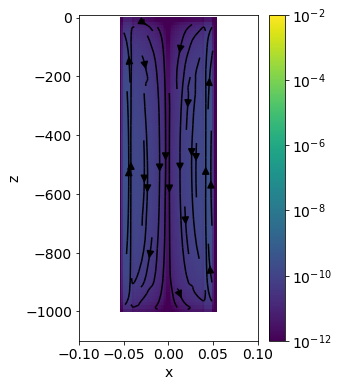

In [153]:
fig, ax = plt.subplots(1, 1, figsize=(4, 6))
plot_rho_j(
    survey.srcList[0], tind=tind, theta_ind=3, ax=ax, xlim=0.1*np.r_[-1, 1], 
#         zlim = [-10, 10],
    zlim=[-1.1*model_dict["casing"].casing_l, 10],
    term=2, 
    clim=np.r_[1e-12, 1e-2]
    )

In [160]:
def plot_se_error(src, tind, theta_ind=0, key="approx_casing", primary_key="casing", term=None, ax=None, clim=None, xlim=None, zlim=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    
    eps = 1e-10
    if term in [0, 1]:
        plotme = compute_se_error(src, tind, key, primary_key, separate=True)[term]
    else:
        plotme = compute_se_error(src, tind, key, primary_key)

    theta_ind_mirror = theta_index_mirror(theta_ind)
    plt_vec = casingSim.utils.face3DthetaSlice(mesh, plotme, theta_ind=theta_ind)
    mirror_data = casingSim.utils.face3DthetaSlice(mesh, plotme, theta_ind=theta_ind_mirror)
    plot_type = "vec"
    
    mesh2D = discretize.CylMesh([mesh.hx, 1, mesh.hz], x0=mesh.x0)
    
    out = casingSim.view.plotFace2D(
        mesh2D, plt_vec, ax=ax, range_x=xlim, range_y=zlim,
        sample_grid=(
            np.r_[np.diff(xlim)/100., np.diff(zlim)/100.]
#             if xlim is not None and zlim is not None else None
        ),
        log_scale=True,
        clim=clim,
        stream_threshold=clim[0] if clim is not None else None,
        mirror=True,
        mirror_data=mirror_data,
        stream_opts = {"color": "k", "arrowsize": 1.5, "density": 0.8}
    )
    
    ax.set_xlim(xlim)
    ax.set_ylim(zlim)
    ax.set_title(f"electric source term \n t={sim.times[tind]:1.1e}s")
    
    return ax, out[-1]
    


In [161]:
def widget_se(tind, theta_ind, clim_min, clim_max, term):
    fig, ax = plt.subplots(1, 1, figsize=(4, 6))
    plot_se_error(
        survey.srcList[0], tind=tind, theta_ind=theta_ind, ax=ax, xlim=0.1*np.r_[-1, 1], zlim=[-1.1*model_dict["casing"].casing_l, 10],
        clim=np.r_[clim_min, clim_max], term=term, 
    )

ipywidgets.interact(
    widget_se, 
    tind = ipywidgets.IntSlider(min=0, max=sim.nT+1, value=0),
    theta_ind = ipywidgets.IntSlider(min=0, max=len(mesh.hy), value=3),
    clim_min = ipywidgets.FloatText(value=1),
    clim_max = ipywidgets.FloatText(value=1e8),
    term = ipywidgets.ToggleButtons(options=[0, 1, 2], value=2)
)

interactive(children=(IntSlider(value=0, description='tind', max=188), IntSlider(value=3, description='theta_i…

<function __main__.widget_se(tind, theta_ind, clim_min, clim_max, term)>

In [162]:
from string import ascii_lowercase

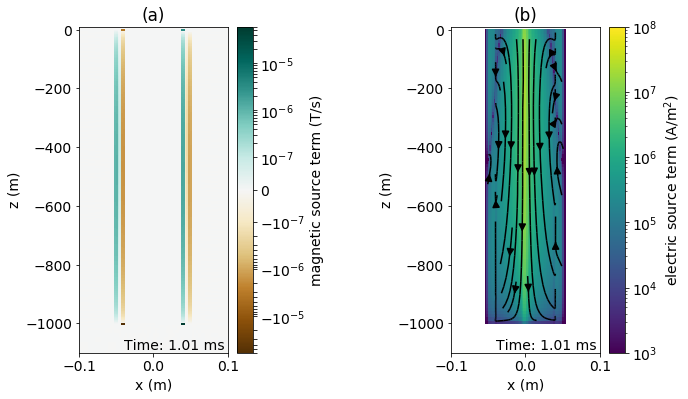

In [171]:
## plot the electric and magnetic source terms at a fixed time
tind = 73
source_ind = 0
theta_ind = 3
xlim = 0.1*np.r_[-1, 1]
zlim = [-1.1*model_dict["casing"].casing_l, 10]
term = 2

fig, ax = plt.subplots(1, 2, figsize=(10, 6), gridspec_kw={"wspace": 1})

_, cm = plot_sm_error(
        survey.srcList[source_ind], tind=tind, theta_ind=theta_ind, ax=ax[0], xlim=xlim, 
        zlim=zlim,
        clim=np.r_[1e-7, 6e-5], term=term, 
    )
_, ce = plot_se_error(
        survey.srcList[source_ind], tind=tind, theta_ind=theta_ind, ax=ax[1], xlim=xlim, zlim=zlim,
        clim=np.r_[1e3, 1e8], term=term, 
    )

for i, a in enumerate(ax):
    a.set_xlabel("x (m)")
    a.set_ylabel("z (m)")
    a.set_title(f"({ascii_lowercase[i]})")
    a.text(0.095, -1090, "Time: {:.2f} ms".format(sim.times[tind]*1e3), horizontalalignment="right", fontsize=14) 

cm.set_label("magnetic source term (T/s)")
ce.set_label("electric source term (A/m$^2$)")


fig.savefig('../figures/source-terms.png', dpi=100, bbox_inches="tight")
fig.savefig('../arxiv-figures/source-terms.png', dpi=50, bbox_inches="tight")

In [164]:
def compute_jdiff_rhs(src, tind=None, key="approx_casing", primary_key="casing"):
    
    C = mesh.edgeCurl
    MfRho = mesh.getFaceInnerProduct(1./model_dict[key].sigma(mesh))
    MeMuI = sim.MeMuI 
    j = fields_dict[key][src, 'j', tind]
    je = fields_dict[primary_key][src, 'j', tind] - j
    dt = sim.timeSteps[tind]
    
    return C * MeMuI * C.T * MfRho * je + 1./dt * je

In [165]:
def compute_sm_rhs(src, tind=None, key="approx_casing", primary_key="casing"):
    C = mesh.edgeCurl
#     MfRho = mesh.getFaceInnerProduct(1./model_dict[key].sigma(mesh))
    MeMuI = sim.MeMuI 
    
    rhs = C * MeMuI * compute_sm_error(src, tind, key, primary_key)
    if tind > 0:
        j = fields_dict[key][src, 'j', tind-1]
        je = fields_dict[primary_key][src, 'j', tind-1] - j
        dt = sim.timeSteps[tind]
        rhs += 1/dt * je
    
    return rhs

In [166]:
tind = 10
srcind = 0

jdiff_rhs = compute_jdiff_rhs(survey.source_list[srcind], tind)
sm_rhs = compute_sm_rhs(survey.source_list[srcind], tind)
sm = compute_sm_error(survey.source_list[srcind], tind)

/global/u2/l/lheagy/git/simpeg/simpeg/SimPEG/simulation.py:479: UserWarning: timeSteps will be depreciated in favor of time_steps. Please update your code accordingly
  "timeSteps will be depreciated in favor of time_steps. "


In [167]:
smx = sm[:mesh.vnE[0]]
smy = sm[mesh.vnE[0]:mesh.vnE[:2].sum()]
smz = sm[mesh.vnE[:2].sum():]

In [168]:
smx.min(), smx.max(), smy.min(), smy.max(), smz.min(), smz.max()

(-1.0607583795024963e-08,
 1.0607583813398484e-08,
 -1.7740922189763744e-05,
 0.0009428996144665249,
 -3.9482725042511956e-07,
 3.948272503447054e-07)

In [169]:
f"{np.linalg.norm(jdiff_rhs):1.2e}, {np.linalg.norm(sm_rhs):1.2e}, {np.linalg.norm(jdiff_rhs-sm_rhs):1.2e}"

'2.98e+10, 2.98e+10, 2.17e+04'

In [ ]:
jdiff_rhs_x = jdiff_rhs[:mesh.vnF[0]]
sm_rhs_x = sm_rhs[:mesh.vnF[0]]

jdiff_rhs_y = jdiff_rhs[mesh.vnF[0]:mesh.vnF[:2].sum()]
sm_rhs_y = sm_rhs[mesh.vnF[0]:mesh.vnF[:2].sum()]

jdiff_rhs_z = jdiff_rhs[mesh.vnF[:2].sum():]
sm_rhs_z = sm_rhs[mesh.vnF[:2].sum():]

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(12, 12))

ax[0, 0].semilogy(np.abs(jdiff_rhs_x), '.', alpha=0.5)
ax[0, 0].semilogy(np.abs(sm_rhs_x), '.', alpha=0.5)
ax[0, 1].semilogy(np.abs(sm_rhs_x - jdiff_rhs_x), '.', alpha=0.5)

ax[1, 0].semilogy(np.abs(jdiff_rhs_y), '.', alpha=0.5)
ax[1, 0].semilogy(np.abs(sm_rhs_y), '.', alpha=0.5)
ax[1, 1].semilogy(np.abs(sm_rhs_y - jdiff_rhs_y), '.', alpha=0.5)

ax[2, 0].semilogy(np.abs(jdiff_rhs_z), '.', alpha=0.5)
ax[2, 0].semilogy(np.abs(sm_rhs_z), '.', alpha=0.5)
ax[2, 1].semilogy(np.abs(sm_rhs_z - jdiff_rhs_z), '.', alpha=0.5)

for a in ax[0, :]:
    a.set_ylim([1e1, 1e7])
    
for a in ax[1, :]:
    a.set_ylim([1e-2, 1e4])

for a in ax[2, :]:
    a.set_ylim([1e4, 1e10])

plt.tight_layout()

In [ ]:
interesting_inds = np.abs(jdiff_rhs_y) > 10

In [ ]:
grid_locs = mesh.gridFy[utils.mkvc(interesting_inds), :]
print(grid_locs[:, 0].min(), grid_locs[:, 0].max())
print(grid_locs[:, 2].min(), grid_locs[:, 2].max())

In [ ]:
def plot_rhs_faces(src, tind, theta_ind=0, view="diff", ax=None, clim=None, xlim=None, zlim=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)

    jdiff_rhs = compute_jdiff_rhs(survey.source_list[srcind], tind)
    sm_rhs = compute_sm_rhs(survey.source_list[srcind], tind)

    jdiff_rhs_y = jdiff_rhs[mesh.vnF[0]:mesh.vnF[:2].sum()]
    sm_rhs_y = sm_rhs[mesh.vnF[0]:mesh.vnF[:2].sum()]
    
    if view == "rhs":
        plotme = utils.mkvc(jdiff_rhs_y)
    elif view == "sm":
        plotme = utils.mkvc(sm_rhs_y)
    elif view == "diff":
        plotme = utils.mkvc(jdiff_rhs_y - sm_rhs_y)
    
    plotme = mesh.aveFy2CC * plotme
    
    theta_ind_mirror = theta_index_mirror(theta_ind)
    plotme = plotme.reshape(mesh.vnC, order="F")
    mirror_data = discretize.utils.mkvc(-plotme[:, theta_ind_mirror, :])
    plotme = discretize.utils.mkvc(plotme[:, theta_ind, :])

    norm = SymLogNorm(
        clim[0] if clim is not None else
        np.max([1e-12, np.min(np.absolute(plotme))])
    )
    clim = clim[1]*np.r_[-1., 1.] if clim is not None else None
    
    mesh2D = discretize.CylMesh([mesh.hx, 1, mesh.hz], x0=mesh.x0)
    
    out = mesh2D.plotImage(
        plotme, ax=ax, pcolorOpts = {'norm': norm}, clim=clim,
        mirror_data=mirror_data, mirror=True, grid=False
    )
    
    plt.colorbar(out[0])
    
    ax.set_xlim(xlim)
    ax.set_ylim(zlim)
    ax.set_title(f"{view} \n t={sim.times[tind]:1.1e}s")
    

In [ ]:
def widget_rhs(tind, src_ind, theta_ind, clim, r, depthmin, depthmax, view):
    fig, ax = plt.subplots(1, 1, figsize=(4, 6))
    plot_rhs_faces(
        survey.srcList[src_ind], 
        tind=tind, 
        theta_ind=theta_ind, 
        xlim=r*np.r_[-1, 1], 
        zlim=[-depthmax, depthmin],
        clim=clim if clim!=0 else None,
        ax=ax,
        view=view,
    )

ipywidgets.interact(
    widget_rhs, 
    tind = ipywidgets.IntSlider(min=0, max=sim.nT+1, value=0),
    src_ind = ipywidgets.IntSlider(min=0, max=len(survey.source_list)-1, value=0),
    theta_ind = ipywidgets.IntSlider(min=0, max=len(mesh.hy), value=3),
    clim = ipywidgets.FloatText(value=0),
    r = ipywidgets.FloatText(value=0.1),
    depthmin = ipywidgets.FloatText(value=10),
    depthmax = ipywidgets.FloatText(value=1.1*model_dict["casing"].casing_l),
    view = ipywidgets.ToggleButtons(options=["rhs", "sm", "diff"], value="diff")
)

In [ ]:
sm = compute_sm_error(survey.srcList[0], tind = 0, key="approx_casing", primary_key="casing", separate=False)

In [ ]:
smx = sm[:mesh.vnE[0]]
smy = sm[mesh.vnE[0]:mesh.vnE[:2].sum()]
smz = sm[mesh.vnE[:2].sum():]

In [ ]:
smz.shape, mesh.nEz

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
eps = 1e-3*np.max(abs(sm))
tind = 0

for a, s in zip(ax, [smx, smy, smz]):
    a.semilogy(np.abs(s))
    a.set_ylim(eps, np.max(abs(sm)))

    plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.hist(np.log10(np.abs(smy + 1e-30)), bins = 200)
ax.set_ylim([0, 1e3])

In [ ]:
smy = smy.reshape(mesh.vnEy, order="F")

In [ ]:
from matplotlib import cm as cmap

In [ ]:
fig, ax = plt.subplots(3, 1, figsize = (6, 9))
theta_ind = 3
src_ind = 0
tind = 0

sm = compute_sm_error(survey.srcList[src_ind], tind=tind, key="approx_casing", primary_key="casing", separate=False)
smy = sm[mesh.vnE[0]:mesh.vnE[:2].sum()]
smy = smy.reshape(mesh.vnEy, order="F")

rinds = np.where((mesh.vectorNx >= model.casing_a*0.9) & (mesh.vectorNx <= model.casing_b))[0][[0, -1]] 
colors = cmap.viridis(np.linspace(0, 1, len(rinds)))

for val in range(rinds[0], rinds[1]+1):
    plotme = smy[val, 3, :]
    print(np.max(np.abs(plotme)))
    pos_inds = plotme > 0
    neg_inds = plotme < 0
    
    if np.any(pos_inds):
        ax[0].semilogy(mesh.vectorNz[pos_inds], plotme[pos_inds], '.', color='C0')
    if np.any(neg_inds):
        ax[0].semilogy(mesh.vectorNz[neg_inds], -plotme[neg_inds],'.', color='C1')


R = np.repeat(np.atleast_2d(mesh.vectorNx[rinds[0]+1:rinds[1]+2]), len(mesh.vectorNz), axis=0).T
ax[1].semilogy(mesh.vectorNz, (smy[rinds[0]:rinds[1]+1, theta_ind, :]*R).sum(0)/model.casing_b, '.', color='C0')
# ax[1].semilogy(mesh.vectorNz, -(smy[rinds[0]:rinds[1]+1, theta_ind, :]*R).sum(0)/model.casing_b, '.', color='C1')

for a in ax:
    a.set_xlim([20, -model.casing_l*1.5])
#     a.set_ylim([1e-9, 1e-4])

ax[2].plot(mesh.vectorNz, np.abs(smy[rinds[0], theta_ind, :]*mesh.vectorNx[rinds[0]+1] + (smy[rinds[1], 3, :]*mesh.vectorNx[rinds[1]+1])), '.')
ax[2].set_ylim(1e-10*np.r_[-1, 1])



In [ ]:
def compute_sm_source_term(src, key="approx_casing", primary_key="casing", safe=True, radius=model.casing_b):
    # safe assigns zero outside the region of the casing in order to avoid accumulation of numerical errors 
    
    sm = compute_sm_error(src, None, key, primary_key)
    sm = sm[mesh.vnE[0]:mesh.vnE[:2].sum(), :]  # only the y-component
    sm = sm.reshape(list(mesh.vnEy) + [sim.nT], order="F")
    sm = sm.mean(1) # take the mean around the theta edges (they are basically identical)
    
    if safe is True:
        rinds = np.where(mesh.vectorNx[1:]<=radius)[0]
        rinds = slice(rinds[0], rinds[-1]+2)
        zinds = np.where((mesh.vectorNz <= 0) & (mesh.vectorNz >= -model.casing_l))[0]
        zinds = slice(zinds[0], zinds[-1]+2)
        sm = sm[rinds, zinds, :]
        R = np.squeeze(mesh.gridEy[:, 0].reshape(mesh.vnEy, order="F")[rinds, 0, zinds])
#         print(R)
    
    else: 
        R = np.squeeze(mesh.gridEy[:, 0].reshape(mesh.vnEy, order="F")[:, 0, :])
        
    R = np.repeat(R.reshape(R.shape + (1,)), sim.nT, axis=2)
    
    return rinds, zinds, (sm*R).sum(0)/radius

In [ ]:
rinds, zinds, src_term = compute_sm_source_term(survey.source_list[0])

In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot(mesh.vectorNz[zinds], src_term[:, 0], '.')
ax.set_xlim([20, -model.casing_l*1.5])

In [ ]:
src_term.shape

In [ ]:
len(mesh.vectorNz[zinds])

In [ ]:
fig, ax = plt.subplots(1, 1)

# plt.colorbar(
#     ax.pcolormesh(sim.time_mesh.vectorCCx, z, src_term, norm=SymLogNorm(linthresh=1e-9, vmax=1e-4, vmin=-1e-4), cmap='BrBG'),
#     ax=ax
# )

cb = plt.colorbar(
    ax.pcolormesh(sim.time_mesh.vectorCCx, mesh.vectorNz[zinds], src_term, norm=SymLogNorm(linthresh=1e-8, vmax=3e-5, vmin=-3e-5), cmap="BrBG"),
    ax=ax
)

ax.set_xscale('log')
# ax.set_xlim([1e-7, 1e-5])
ax.set_xlabel("time (s)")
ax.set_ylabel("z (m)")
cb.set_label("source term")

In [ ]:
fig = plt.figure()
ax = fig.gca(projection='3d')

clim = np.r_[1e-15, 1e-4]
X, Y = np.meshgrid(np.log10(sim.time_mesh.vectorCCx), mesh.vectorNz[zinds])
plt.colorbar(
    ax.plot_surface(
        X, Y, np.log10(-1*(src_term)), 
        rstride=1, cstride=1, cmap="viridis", 
        edgecolor='none', 
        vmin=np.log10(clim.min()),
        vmax=np.log10(clim.max())
        #vmin=np.log10(clim.min()), vmax=np.log10(clim.max())), # , norm=LogNorm(vmin=clim.min(), vmax=clim.max())),

    ),
    ax=ax
)
ax.set_ylim(np.r_[-model.casing_l, 0.])
ax.set_zlim(np.log10(clim))
# ax.set_xscale('log')

In [ ]:
from matplotlib import colors
from matplotlib import cm as cmap

In [ ]:
src_term.shape

In [ ]:
nT = 100

cm = plt.get_cmap('viridis')
c_norm = LogNorm(vmin=sim.time_mesh.vectorCCx[0], vmax=sim.time_mesh.vectorCCx[nT])
scalar_map = cmap.ScalarMappable(norm=c_norm, cmap=cm)
scalar_map.set_array([])
# colors = cm.viridis(np.linspace(0, 1, nT))

fig, ax = plt.subplots(2, 1, figsize=(12, 8))

for time_ind in range(nT)[::int(nT/30)]:
    plotme = src_term[:, time_ind]
    pos_vals = plotme > 0. 
    neg_vals = plotme < 0.
    
    color = scalar_map.to_rgba(sim.time_mesh.vectorCCx[time_ind])

    if any(pos_vals):
        ax[0].semilogy(
            mesh.vectorNz[zinds][pos_vals], plotme[pos_vals],
            color=color, marker='s', ls='None'
        )
    if any(neg_vals):
        ax[0].semilogy(
            mesh.vectorNz[zinds][neg_vals], -plotme[neg_vals], 
            color=color, marker='.', ls='None'
        )
    
    ax[1].plot(
        mesh.vectorNz[zinds], plotme, 
        color=color, marker='.', ls='None'
    )

for a in ax:
    a.set_xlim([10, -model.casing_l-10])
    a.grid(which="both", color="k", lw=0.5, alpha=0.5)
    a.set_xlabel("depth (m)")
    a.set_ylabel("source term (V/m$^2$)")
    
# ax[0].set_ylim([1e-15, 3e-5])
# ax[1].set_ylim(1e-6*np.r_[-1, 1e-1])
cbar_ax = fig.add_axes([1, 0.1, 0.02, 0.8])
cb = plt.colorbar(scalar_map, cbar_ax)
cb.set_label('time (s)')
cb.ax.invert_yaxis()

plt.tight_layout()

In [ ]:
from matplotlib.colors import Normalize

In [ ]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

nT = sim.nT-1

cm = plt.get_cmap('viridis_r')
zlim = np.r_[-15, -5]

c_norm = Normalize(vmin=zlim.min(), vmax=zlim.max())
scalar_map = cmap.ScalarMappable(norm=c_norm, cmap=cm)
scalar_map.set_array([])

alpha = 0.1

for time_ind in range(nT):

    plotme = src_term[:, time_ind]
    pos_vals = plotme > 0. 
    neg_vals = plotme < 0.

    time = sim.time_mesh.vectorCCx[time_ind]

#     if any(pos_vals):
#         ax.scatter(
#             mesh.vectorNz[zinds][pos_vals], np.log10(np.r_[time]), np.log10(plotme[pos_vals]),
#             color=color, marker='s', ls='None', alpha=alpha
#         )
    if any(neg_vals):
        
        zvals = np.log10(-plotme[neg_vals])
        cols = scalar_map.to_rgba(zvals)
        
        ax.scatter(
            mesh.vectorNz[zinds][neg_vals], np.log10(np.r_[time]), zvals, 
            color=cols, marker='.', ls='None', alpha=alpha
        )


xlim = np.r_[10, -model.casing_l*1.1]
ax.set_xlim(xlim)
ax.set_zlim(zlim)


ax.set_xlabel("depth (m)")
ax.set_ylabel("log10(time)")
ax.set_zlabel("source term (V/m$^2$)")

X = mesh.vectorNz[zinds]
Y = np.log10(sim.time_mesh.vectorCCx[0:nT])
Z = src_term[:, 0:nT].T
neg_vals = Z < 0. 
Z = np.ma.array(np.log10(-Z), mask=~neg_vals)

X, Y = np.meshgrid(X, Y)

# cset = ax.contour(X, Y, Z, 20, zdir='z', offset=zlim.min(), cmap=cmap.viridis)
# cset = ax.contour(X, Y, Z, 20, zdir='x', offset=xlim.max(), cmap=cmap.viridis)
# cset = ax.contour(X, Y, Z, zdir='z', offset=zlim.min(), cmap=cmap.gray)
# cset = ax.contour(X, Y, Z, zdir='x', offset=-40, cmap=cm.gray)
# cset = ax.contour(X, Y, Z, zdir='y', offset=40, cmap=cm.gray)

ax.view_init(30, 15)



# create a TDEM source

In [ ]:
import properties
from SimPEG.electromagnetics.time_domain.sources import BaseTDEMSrc, BaseWaveform

In [ ]:
class RawVecSm(BaseTDEMSrc):
    
    _s_m = properties.Array("numpy aray of the source term", shape=('*', '*'))
    
#     indices = properties.Array("numpy array containing the indicies where the source term is located on the mesh", dtype=bool)
    rind = properties.Integer("radial location of the source term")
    zinds = properties.Array("z locations of the source term")
    
    def __init__(self, receiver_list, waveform=None, s_m=None, **kwargs):
        super(BaseTDEMSrc, self).__init__(**kwargs)
        self.srcType="inductive"
        self._s_m = s_m
        self.waveform = BaseWaveform()
        self.waveform.hasInitialFields = False
        
    def s_m(self, simulation, time_index):
        mesh = simulation.mesh
        if self.rind is not None:
            smy = np.zeros(mesh.vnEy)
            smy[self.rind, :, self.zinds] = np.repeat(np.atleast_2d(self._s_m[:, time_index]), mesh.vnEy[1], axis=0).T
            sm = np.hstack([np.zeros(mesh.nEx), utils.mkvc(smy), np.zeros(mesh.nEz)])
#             sm[self.indices] = self._s_m[:, time_index]
        else:
            sm = self._s_m[:, time_index]
        return sm

In [ ]:
source_list_discrepancy = []

for src in survey.source_list:
    rinds, zinds, sm = compute_sm_source_term(src)
    indices = np.zeros(mesh.vnEy, dtype=bool)
    indices[rinds.stop-1, :, zinds] = True
    indices = np.where(np.hstack([np.zeros(mesh.nEx, dtype=bool), utils.mkvc(indices), np.zeros(mesh.nEz, dtype=bool)])[0])
    
    source_list_discrepancy.append(RawVecSm([], s_m=sm, rind=rinds.stop-1, zinds=np.arange(zinds.start, zinds.stop)))

In [ ]:
survey_discrepancy = tdem.Survey(source_list_discrepancy)
sim_discrepancy = tdem.Problem3D_j(
    mesh=mesh, survey=survey_discrepancy, sigmaMap=maps.IdentityMap(mesh), solver=Pardiso,
    time_steps=timeSteps
)

In [ ]:
if use_cluster is True: 
    cluster = dask_jobqueue.SLURMCluster(
        cores=1,
        processes=1, memory='120GB', 
        job_cpu=2,
        project="m3384",
        job_extra = ['--constraint=haswell', '--qos=debug',], 
        death_timeout=360,
    )

    print(cluster.job_script())

In [ ]:
client

In [ ]:
cluster.adapt(1)

In [ ]:
def run_discrepancy_simulation(m, simulation_params, directory=None, name=None):
    import discretize
    import casingSimulations as casing_sim
    from SimPEG.electromagnetics import time_domain as tdem
    from pymatsolver import Pardiso
    import properties
    from SimPEG.electromagnetics.time_domain.sources import BaseTDEMSrc, BaseWaveform
    
    class RawVecSm(BaseTDEMSrc):
    
        _s_m = properties.Array("numpy aray of the source term", shape=('*', '*'))

    #     indices = properties.Array("numpy array containing the indicies where the source term is located on the mesh", dtype=bool)
        rind = properties.Integer("radial location of the source term")
        zinds = properties.Array("z locations of the source term", dtype=int)

        def __init__(self, receiver_list, waveform=None, s_m=None, **kwargs):
            if kwargs.get("_s_m", None) is not None:
                s_m = kwargs.pop("_s_m")
            super(BaseTDEMSrc, self).__init__(**kwargs)
            self.srcType="inductive"
            self._s_m = s_m
            self.waveform = BaseWaveform()
            self.waveform.hasInitialFields = False

        def s_m(self, simulation, time_index):
            mesh = simulation.mesh
            if self.rind is not None:
                smy = np.zeros(mesh.vnEy)
                smy[self.rind, :, self.zinds] = np.repeat(np.atleast_2d(self._s_m[:, time_index]), mesh.vnEy[1], axis=0).T
                sm = np.hstack([np.zeros(mesh.nEx), utils.mkvc(smy), np.zeros(mesh.nEz)])
    #             sm[self.indices] = self._s_m[:, time_index]
            else:
                sm = self._s_m[:, time_index]
            return sm
        
    if isinstance(simulation_params, str):
        simulation_params = json.loads(simulation_params)
    
    sim = tdem.Problem3D_j.deserialize(simulation_params, trusted=True)
    
    if isinstance(m, str):
        model = casing_sim.model.CasingInHalfspace.deserialize(json.loads(m), trusted=True)
        m = model.sigma(sim.mesh)
    
    sim.solver = Pardiso
    sim.verbose = True
    
    fields = sim.fields(m)
    f = fields[:, '{}Solution'.format(sim._fieldType), :]
    if name is not None: 
        filename = f"{name}.npy"
        tosave = os.path.sep.join([directory, filename]) 
        print(f"saving {tosave}")
        np.save(tosave, f)
    return tosave
    

In [123]:
f_discrepancy = {}

key = "approx_casing"
value = physprops_dict[key]
time = datetime.datetime.now()
model = model_dict[key]
directory = f"{time.year}{time.month}{time.day}{time.hour}{os.path.sep}{int(model.casing_l)}m_sigma{model.sigma_back:1.0e}"

if not os.path.isdir(directory):
    os.makedirs(directory, exist_ok=True)

model.save(f"{key}.json", directory)

f_discrepancy[key] = dask.delayed(run_discrepancy_simulation)(
    value.sigma, sim_discrepancy.serialize(), directory, key
)

# f_discrepancy[key] = run_discrepancy_simulation(
#     value.sigma, sim_discrepancy.serialize(), directory, key
# )
    
    

Saved 201991415/1000m_sigma1e-02/approx_casing.json


## TODO: this should be a 2D simulation

In [124]:
# fields_file_discrepancy = dask.compute(f_discrepancy)[0]

In [128]:
# f_discrep = np.load("./2019915/approx_casing.npy")
f_discrep = np.load("20199120/1000m_sigma1e-02/approx_casing.npy")
# f_discrep = np.load(fields_file_discrepancy) 

In [129]:
sim_discrepancy.model = value.sigma
fields_discrep = sim_discrepancy.fieldsPair(sim_discrepancy)
fields_discrep[:, f'{formulation}Solution', :] = f_discrep

fields_discrep_corrected = sim_discrepancy.fieldsPair(sim_discrepancy)
fields_discrep_corrected[:, f'{formulation}Solution', :] = f_discrep + fields_dict["approx_casing"][:, f'{formulation}Solution', :]

In [130]:
new_model_names = ["discrepancy", "discrepancy_corrected"]
survey_dict={key: sim.survey for key in model_names}
for key, f in zip(new_model_names, [fields_discrep, fields_discrep_corrected]):
    if key not in model_names: 
        model_names.append(key)
    fields_dict[key] = f
    model_dict[key] = model_dict["approx_casing"]
    survey_dict[key] = sim_discrepancy.survey

In [131]:
viewer = casingSim.FieldsViewer(
    mesh=mesh, model_parameters_dict=model_dict, survey_dict=survey_dict, 
    fields_dict=fields_dict, model_keys=model_names, primary_key="casing"
)

In [132]:
out1 = viewer.widget_cross_section(
    defaults={
        "max_depth":1.1*model.casing_l,
        "min_depth":-10,
        "max_r":0.15,
        "theta_ind":3, 
        "view":"j"
    }
)
out1

/global/u2/l/lheagy/git/simpeg/simpeg/SimPEG/survey.py:369: UserWarning: srcList has been renamed to source_list. Please update your code accordingly
  "srcList has been renamed to source_list. Please update your code "


interactive(children=(FloatText(value=0.15, description='max_r'), FloatText(value=-10.0, description='min_dept…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

In [133]:
viewer.widget_cross_section(
    defaults={
        "max_depth":1.5*model.casing_l,
        "min_depth":-10,
        "max_r":1.5*model.casing_l,
        "theta_ind":3,
        "view":"j"
    }, 
    figwidth=12
)

interactive(children=(FloatText(value=1500.0, description='max_r'), FloatText(value=-10.0, description='min_de…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

16.783662990977373


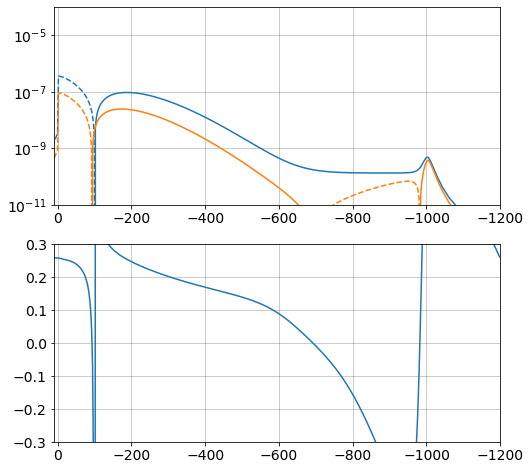

In [134]:
xind = 50
thetaind = 3
tind = 30
src_ind = 0

print(mesh.vectorNx[xind+1])

j_diff = fields_dict["approx_casing"][survey.source_list[src_ind], 'j', tind] - fields_dict["casing"][survey.source_list[src_ind], 'j', tind]
j_discrep = fields_dict["discrepancy"][survey_discrepancy.source_list[src_ind], 'j', tind]

j_diff_x = j_diff[:mesh.vnE[0]].reshape(mesh.vnEx, order="F")
j_discrep_x = j_discrep[:mesh.vnE[0]].reshape(mesh.vnEx, order="F")

fig, ax = plt.subplots(2, 1, figsize=(8, 8))

ax[0].semilogy(mesh.vectorNz, j_diff_x[xind, thetaind], "C0")
ax[0].semilogy(mesh.vectorNz, -j_diff_x[xind, thetaind], "C0--")

ax[0].semilogy(mesh.vectorNz, j_discrep_x[xind, thetaind], "C1")
ax[0].semilogy(mesh.vectorNz, -j_discrep_x[xind, thetaind], "C1--")

ax[1].plot(mesh.vectorNz, j_discrep_x[xind, thetaind]/j_diff_x[xind, thetaind] )

ax[0].set_ylim([1e-11, 1e-4])
ax[1].set_ylim(0.3*np.r_[-1, 1])

for a in ax:
    a.grid(which="both", lw=0.5, alpha=0.4, color="k")
    a.set_xlim([10, -1200])